In [13]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 30 09:43:46 2024

@author: Admin
"""

import torch
import torch.nn.functional as F
import math

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features, grid_size) shape which is extremely
        computational heavy.
        """
        regu_activation = torch.norm(self.spline_weight, p=1)
        regu_entropy = torch.norm(
            torch.log1p(torch.exp(-self.spline_weight.abs() * 2)), p=1
        )

        loss = (
            regu_activation * regularize_activation
            + regu_entropy * regularize_entropy
        )
        return loss

class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    @torch.no_grad()
    def update_grid(self, x, margin=0.01):
        for layer in self.layers:
            layer.update_grid(x, margin=margin)

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        loss = sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )
        return loss

# Example usage



In [14]:

# Sample data

import pandas as pd
local='D://job//FPT.csv'
df_raw=pd.read_csv(local)
df_raw.head()
df_train=df_raw.iloc[:,2:5]
df_test=df_raw.iloc[:,5]
# Chuyển đổi cột 'date' thành datetime
df_raw['Date/Time'] = pd.to_datetime(df_raw['Date/Time'])

# Tạo cột 'month_day' chỉ chứa tháng và ngày
df_raw['year-month-day'] = df_raw['Date/Time'].dt.strftime('%Y-%m-%d')
average_values = df_raw.groupby('year-month-day')[['Open', 'High', 'Low','Close']].mean().reset_index()

In [15]:
average_values.head()

,year-month-day,Open,High,Low,Close
0,2018-12-25,30.760000,30.781429,30.744286,30.760000
1,2018-12-26,31.048016,31.054683,31.042857,31.050159
2,2018-12-27,31.332537,31.335821,31.327313,31.331567
3,2018-12-28,31.322213,31.326803,31.318525,31.321557
4,2019-01-02,31.231709,31.238376,31.224188,31.232393


In [16]:
from sklearn.model_selection import train_test_split

dataset = average_values.drop(columns=['year-month-day']).to_numpy()
dt_Train,dt_Test = train_test_split(dataset,test_size=0.2,shuffle=False)

In [24]:
input=dt_Train[:, :3]
out=dt_Train[:, -1:]
val=dt_Test[:, :3]
val_real=dt_Test[:, -1:]
print(dt_Test)
print(val)


[[46.52769608 46.54215686 46.5125     46.52671569]
 [46.9185446  46.93309859 46.90399061 46.9185446 ]
 [46.95630841 46.97056075 46.94252336 46.95630841]
 [47.18417431 47.2016055  47.1662844  47.18463303]
 [47.40955882 47.42230392 47.39338235 47.40416667]
 [47.10395349 47.12627907 47.09093023 47.11069767]
 [47.09075829 47.09905213 47.07559242 47.08838863]
 [47.78581395 47.79883721 47.77209302 47.78581395]
 [47.95324074 47.96990741 47.93472222 47.95023148]
 [46.792723   46.80469484 46.77605634 46.79037559]
 [46.97196532 46.98121387 46.96184971 46.97138728]
 [46.88612565 46.89371728 46.87827225 46.88769634]
 [47.11527778 47.13078704 47.1        47.1150463 ]
 [47.34855769 47.36009615 47.33798077 47.34855769]
 [48.2300905  48.24570136 48.210181   48.22760181]
 [48.77276786 48.79084821 48.75580357 48.77299107]
 [48.56956522 48.58647343 48.55289855 48.56884058]
 [48.62880952 48.64928571 48.6152381  48.63619048]
 [50.565      50.60590909 50.53136364 50.56909091]
 [49.73587963 49.75509259 49.71

In [25]:


inputs = torch.tensor(input, dtype=torch.float32)
outputs = torch.tensor(out, dtype=torch.float32)
model = KAN([3, 64, 1])
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1000):
    # Forward pass
    predictions = model(inputs)
    loss = criterion(predictions, outputs)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/1000], Loss: {loss.item():.4f}')



Epoch [100/1000], Loss: 0.4555
Epoch [200/1000], Loss: 0.0047
Epoch [300/1000], Loss: 0.0041
Epoch [400/1000], Loss: 0.0035
Epoch [500/1000], Loss: 0.0029
Epoch [600/1000], Loss: 0.0017
Epoch [700/1000], Loss: 0.0007
Epoch [800/1000], Loss: 0.0004
Epoch [900/1000], Loss: 0.0002
Epoch [1000/1000], Loss: 0.0001


In [39]:
# Sample prediction
import numpy as np
predict=[]
for i in val :
    sample_input = torch.tensor(i.reshape(1, -1), dtype=torch.float32)
    predicted_output = model(sample_input)
    predict.append(predicted_output.item())

#print('Predicted output:', predicted_output.item())
print(np.array(predict).reshape(-1, 1))

[[46.52278137]
 [46.91282654]
 [46.95050812]
 [47.17842484]
 [47.40139008]
 [47.10166168]
 [47.08157349]
 [47.77723694]
 [47.94493103]
 [46.78570175]
 [46.9645462 ]
 [46.87862015]
 [47.1093483 ]
 [47.34112167]
 [48.2202301 ]
 [48.76304245]
 [48.5599556 ]
 [48.62130737]
 [50.55684662]
 [49.72279739]
 [49.82344818]
 [50.08983231]
 [49.77856445]
 [49.63082886]
 [48.8573494 ]
 [48.91107178]
 [49.40089417]
 [49.01012802]
 [49.2535553 ]
 [49.74780655]
 [50.40322876]
 [50.14295197]
 [50.95591736]
 [51.42046356]
 [51.00041962]
 [51.13562012]
 [50.73746872]
 [50.47558212]
 [50.85280609]
 [50.95344543]
 [50.02234268]
 [50.47275543]
 [50.44207382]
 [50.27681732]
 [50.54713058]
 [50.43753815]
 [50.8723793 ]
 [50.94249344]
 [50.92974854]
 [50.70069122]
 [50.87685013]
 [50.95572281]
 [52.50590897]
 [53.29127502]
 [52.89104843]
 [53.69048691]
 [53.11618423]
 [53.98001862]
 [53.91885376]
 [52.81801987]
 [51.82769394]
 [50.65539169]
 [50.95975113]
 [51.39191055]
 [52.08314514]
 [52.94960403]
 [52.90444

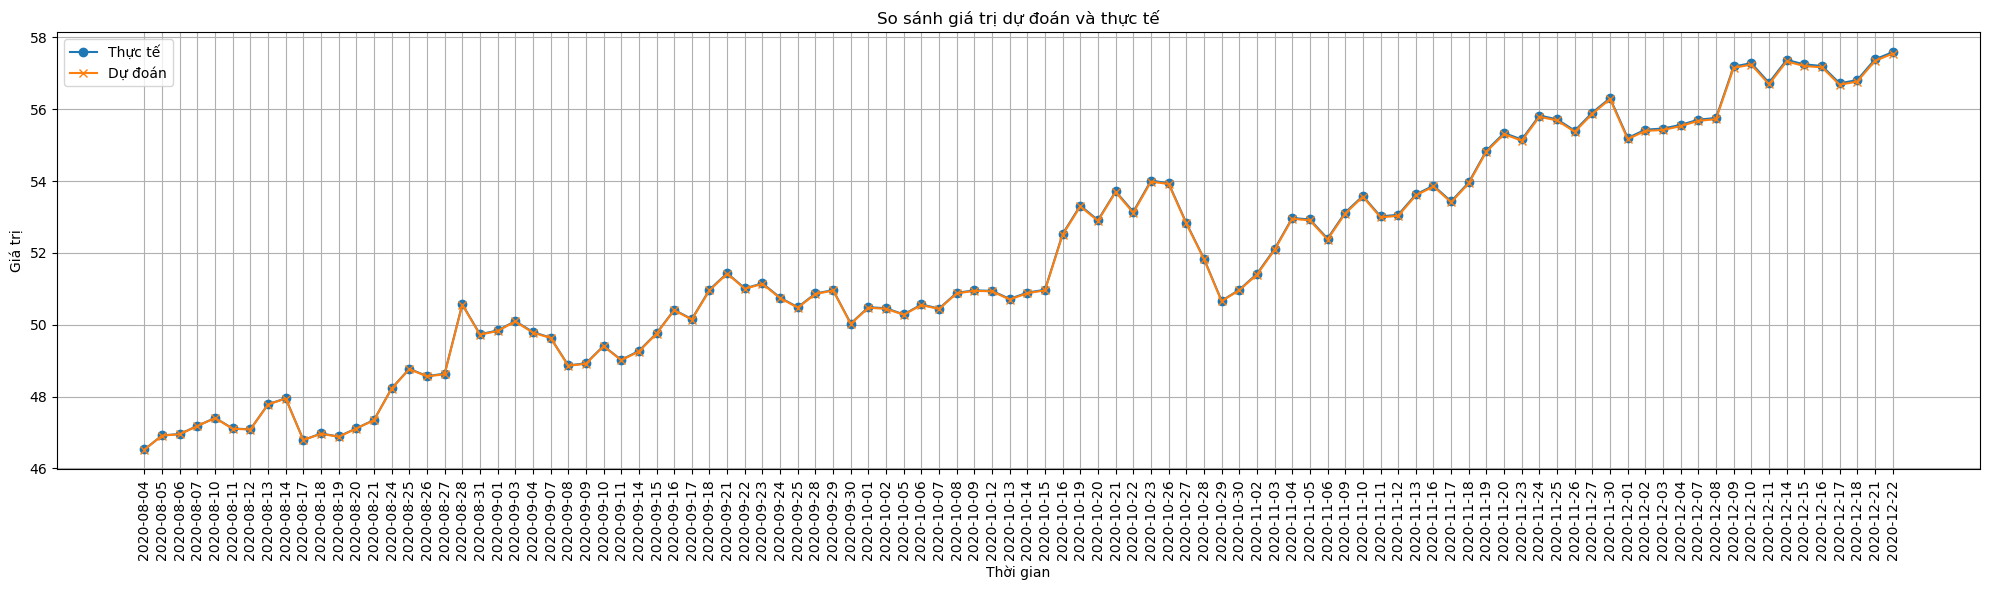

In [44]:
import matplotlib.pyplot as plt
time=average_values['year-month-day'].iloc[-len(val_real):]

plt.figure(figsize=(20, 6))
plt.plot(time,val_real , label='Thực tế', marker='o')
plt.plot(time, np.array(predict).reshape(-1, 1), label='Dự đoán', marker='x')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị dự đoán và thực tế')
plt.xticks(rotation=90)  # Xoay nhãn trục x để dễ đọc
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
print(model.grid_size)
print(model.spline_order)
print(model.layers)


5
3
ModuleList(
  (0-1): 2 x KANLinear(
    (base_activation): SiLU()
  )
)


In [49]:
print(torch.nn.Module.)

<class 'torch.nn.modules.module.Module'>


In [52]:
for i in model.layers :
    print(i)

KANLinear(
  (base_activation): SiLU()
)
KANLinear(
  (base_activation): SiLU()
)
